# Part 2 - Patient Similarity Networks (PSNs)

## Table of Contents

Part 2.

10. **Patient Similarity Network Construction**

11. **DNA Methylation Network Analysis** 

In [4]:
# standard libraries
import os
import pickle

# scientific and data manipulation libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from astropy.stats import median_absolute_deviation
import mygene
import astropy

# graph and network libraries
import networkx as nx

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# import custom functions from the previous notebook
import sys
sys.path.insert(0 , '/tutorial/')
from functions import *

# 10. Patient Similarity Network (PSN)

- Based on the same expression matrix we can create a patient similarity network.
- Transposing the matrix will switch the rows and columns,
- meaning that patients will become the columns instead of genes
- By doing this, you can compute the correlation (or similarity) between patients based on their gene expression profiles,
- and then create a network where nodes represent patients and edges represent similarities.

In [5]:
# main data directories for the project

raw_data_dir = '/data/raw'
intermediate_data_dir = '/data/intermediate'

In [6]:
# read in os.path.join(intermediate_data_dir,"expression_data_filtered.csv")
df_renamed = pd.read_csv(os.path.join(intermediate_data_dir,
                                      "expression_data_filtered.csv"),
                                      index_col=0)

In [11]:
'''
#################################################
                YOUR CODE HERE
#################################################

We will now transpose the df_renamed df so that the rows represent the genes and the columns represent the patients.
Let's call the transposed df patient_gene_matrix.

'''

patient_gene_matrix = df_renamed.T

In [12]:
patient_gene_matrix

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,...,TCGA-97-A4M7,TCGA-62-A46R,TCGA-50-5055,TCGA-38-4628,TCGA-86-7713,TCGA-86-8073,TCGA-MN-A4N4,TCGA-53-7626,TCGA-44-A47G,TCGA-55-6969
A2M,17.7492,14.8513,14.1691,16.7238,15.6783,14.7566,16.4368,15.5476,15.5478,15.1337,...,15.9553,13.9511,16.3097,14.3934,15.8254,16.3773,14.9411,16.7343,15.6622,14.8136
A2ML1,4.4411,4.4530,4.5026,3.1704,4.7422,6.0918,4.0602,3.0827,3.4608,3.6367,...,4.7076,2.4821,8.0810,3.3415,5.3379,4.0817,6.7210,5.2575,3.7345,4.3058
A4GALT,10.1862,8.9312,9.0834,9.1443,9.5150,11.4452,9.1462,7.3597,9.1602,8.9344,...,9.1019,8.6653,10.8837,8.6304,9.3827,9.4234,11.9107,9.5379,9.8660,9.7702
AACSP1,3.5845,3.6762,3.8623,2.4821,3.2271,2.4821,5.6614,3.0827,3.9428,4.7089,...,5.4947,3.0956,2.4821,3.7710,2.9397,6.6519,8.8283,2.4821,4.1045,6.8425
AADAC,9.6415,6.5685,5.5634,4.3206,7.2321,6.8821,8.1176,4.7935,11.7750,7.0644,...,9.0856,3.8162,5.6471,4.6785,4.6578,6.7641,3.4947,5.7120,6.2214,5.2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN23,5.7385,4.3796,5.6728,3.6533,5.0478,6.0489,5.8058,3.7897,4.3451,5.5259,...,4.7076,2.4821,4.6683,3.4697,4.3516,7.2074,6.9167,6.0927,5.3854,3.6792
ZSCAN31,9.0817,10.9565,10.8095,8.9874,9.5810,9.0185,10.2085,9.8803,11.0327,10.2707,...,9.2033,10.5020,8.8073,9.8672,10.6419,10.2410,9.4672,10.0507,7.4843,8.5268
ZSCAN4,3.2709,3.0918,2.4821,3.4468,3.0118,5.0894,5.5341,3.5082,5.4987,3.3645,...,4.4088,7.4937,4.3167,5.0907,6.7676,5.1126,3.3143,4.2816,4.4650,2.4821
ZWINT,9.2615,10.1334,10.9149,9.7828,8.6640,11.1212,9.0718,10.7305,9.0013,10.4268,...,9.7614,10.7593,9.7087,10.4729,10.9794,10.1390,10.0583,9.4627,9.5817,10.8228


In [14]:
'''
#################################################
                YOUR CODE HERE
#################################################

We will now calculate the correlation matrix for the patient_gene_matrix using the Pearson correlation method.
Store the correlation matrix in a dictionary called patient_correlation_matrices with the key 'pearson'.
We don't have to do it, however if you want to calculate the correlation matrix using other methods,
you can do so and store them in the dictionary as well.

'''

# Dictionary to store different correlation matrices
patient_correlation_matrices = {}

# Pearson correlation
patient_correlation_matrices['pearson'] = patient_gene_matrix.corr(method='pearson')

In [15]:
'''
#################################################
                YOUR CODE HERE
#################################################

Create a graph from the correlation matrix using the create_graph_from_correlation function.
Set the threshold to 0.8.
Store the graph in a variable called patient_pearson_graph.

'''

patient_pearson_graph = create_graph_from_correlation(patient_correlation_matrices['pearson'], threshold=0.8)

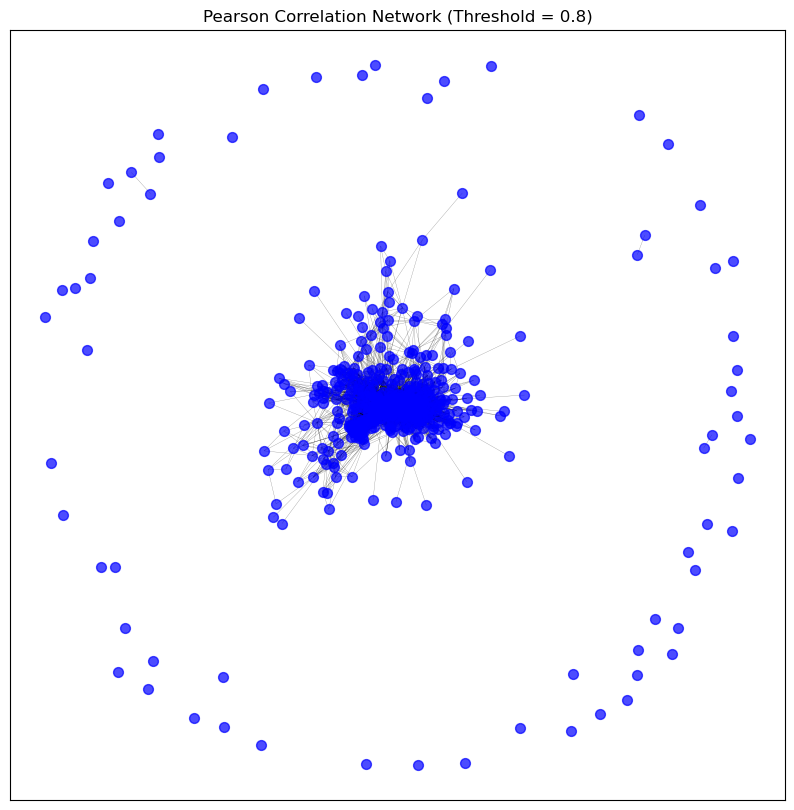

In [20]:
'''
#################################################
                YOUR CODE HERE
#################################################

Visualie the graph using the visualise_graph function.
Use appropriate title for the graph as the second argument.

'''
visualise_graph(patient_pearson_graph, title='Pearson Correlation Network (Threshold = 0.8)')

In [23]:
'''
#################################################
                YOUR CODE HERE
#################################################

Now use clean_graph function to clean the graph called patient_pearson_graph_pruned.
Consider the following parameters:
- degree_threshold
- keep_largest_component

'''
patient_pearson_graph_pruned = clean_graph(patient_pearson_graph,
                                    degree_threshold=1,
                                    keep_largest_component=True)

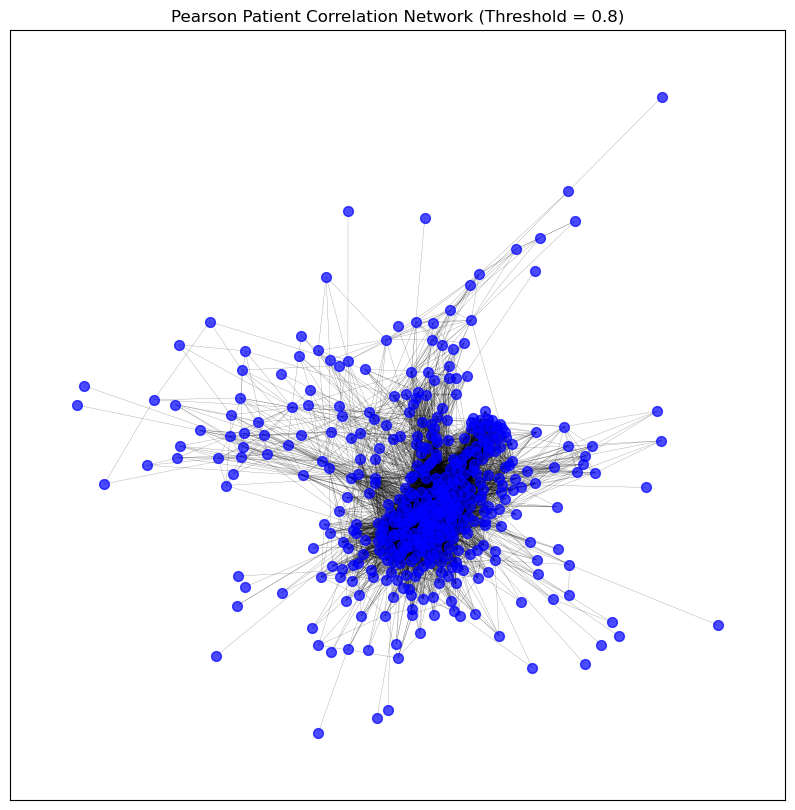

In [22]:
'''
#################################################
                YOUR CODE HERE
#################################################

Visualie the pruned graph using the visualise_graph function.
Use appropriate title for the graph as the second argument.

'''

visualise_graph(patient_pearson_graph_pruned,
                title='Pearson Patient Correlation Network (Threshold = 0.8)')

In [25]:
'''
#################################################
                YOUR CODE HERE
#################################################

 Now do some sparsification of the graph using knn_sparsification function,
 call it patient_pearson_graph_pruned_knn.
 Set the k value to 10.               

'''

patient_pearson_graph_pruned_knn = knn_sparsification(patient_pearson_graph_pruned, k=10)

In [28]:
'''
#################################################
                YOUR CODE HERE
#################################################

Let's see some information about the graph using the print_graph_info function.
First, print the information about the patient_pearson_graph_pruned graph.
Use print("------------------------------------"), as a devide between the two graphs.
Then, print the information about the patient_pearson_graph_pruned_knn graph.            

'''

print_graph_info(patient_pearson_graph_pruned)
print("------------------------------------")
print_graph_info(patient_pearson_graph_pruned_knn)

Number of nodes: 434
Number of edges: 10373
Sample nodes: ['TCGA-38-7271', 'TCGA-55-7914', 'TCGA-73-4658', 'TCGA-86-8076', 'TCGA-55-7726', 'TCGA-44-6147', 'TCGA-50-5932', 'TCGA-44-2661', 'TCGA-86-7954', 'TCGA-73-4662']
Sample edges: [('TCGA-38-7271', 'TCGA-73-4658', {'weight': 0.8696511707884843}), ('TCGA-38-7271', 'TCGA-86-8076', {'weight': 0.8173779911639248}), ('TCGA-38-7271', 'TCGA-44-2661', {'weight': 0.8652686243802332}), ('TCGA-38-7271', 'TCGA-73-4662', {'weight': 0.8446135021161085}), ('TCGA-38-7271', 'TCGA-55-6986', {'weight': 0.833876175940164}), ('TCGA-38-7271', 'TCGA-49-6744', {'weight': 0.8919809060862212}), ('TCGA-38-7271', 'TCGA-69-7763', {'weight': 0.8374050473870502}), ('TCGA-38-7271', 'TCGA-44-6774', {'weight': 0.802120255633156}), ('TCGA-38-7271', 'TCGA-67-3774', {'weight': 0.8179727328277505}), ('TCGA-38-7271', 'TCGA-97-A4M2', {'weight': 0.8045412817214057})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.11039686678515555
Number of connected co

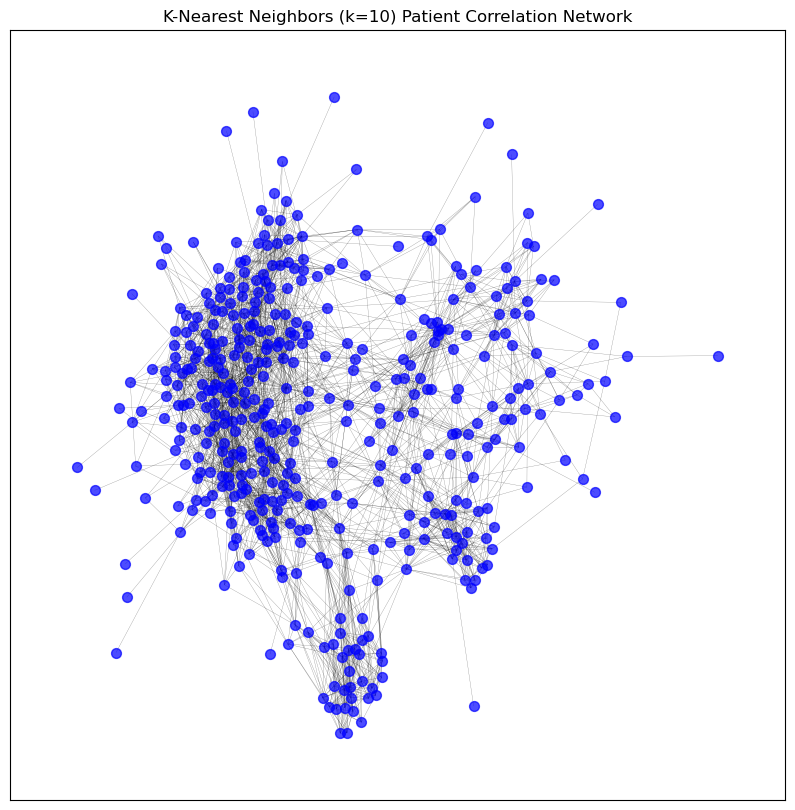

In [29]:
visualise_graph(patient_pearson_graph_pruned_knn, title='K-Nearest Neighbors (k=10) Patient Correlation Network')

# 11. DNA methylation PSN

In the second task, we are preparing an additional network for the same patients, this time based on DNA methylation data.

In [31]:
# Load the data using pickle from the ISMB_TCGA_DNAm.pkl file
with open(os.path.join(raw_data_dir,"ISMB_TCGA_DNAm.pkl") , 'rb') as file : 
    data = pd.read_pickle(file)

# Extract the methylation data from the dictionary similar to the previous data
meth_data = data["datExpr"]
meth_data


,cg23057992,cg16602369,cg20545544,cg04571941,cg23091104,cg11738485,cg17735539,cg12662576,cg10554839,cg08866780,...,cg04339424,cg01318691,cg27068965,cg23028848,cg21122529,cg22254072,cg10237911,cg09874052,cg27624178,cg02857943
TCGA-55-7914,0.039144,0.078881,0.032201,0.098520,0.971626,0.020020,0.929670,0.033325,0.043767,0.028051,...,0.053027,0.046047,0.951328,0.045767,0.048185,0.014262,0.034541,0.034967,0.041538,0.053116
TCGA-38-4631,0.954805,0.047287,0.027976,0.925794,0.144636,0.365842,0.156414,0.027917,0.047609,0.049901,...,0.048398,0.047221,0.939891,0.056141,0.047459,0.014548,0.056591,0.039086,0.044946,0.055473
TCGA-73-4658,0.966071,0.126549,0.030316,0.945166,0.976080,0.975638,0.942018,0.066659,0.052100,0.047054,...,0.040815,0.042040,0.951235,0.045477,0.074037,0.019053,0.029978,0.039345,0.060650,0.041385
TCGA-50-5932,0.965140,0.061194,0.935457,0.923421,0.965443,0.027598,0.040885,0.036178,0.045745,0.046439,...,0.057840,0.045106,0.948255,0.044558,0.039484,0.013837,0.037048,0.032503,0.058576,0.037666
TCGA-55-7576,0.958612,0.071607,0.027077,0.940574,0.976870,0.785073,0.953674,0.945107,0.056088,0.955472,...,0.046921,0.051442,0.954000,0.034352,0.031497,0.014924,0.035520,0.043547,0.056388,0.052208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-50-8457,0.960316,0.940219,0.046927,0.942980,0.977751,0.633731,0.940723,0.053398,0.059292,0.968875,...,0.047640,0.062680,0.954824,0.043137,0.048599,0.014066,0.031109,0.039247,0.035110,0.054273
TCGA-91-6840,0.964250,0.921250,0.957943,0.958416,0.981439,0.278432,0.968525,0.032143,0.083996,0.037912,...,0.045197,0.066271,0.963420,0.047621,0.060854,0.015823,0.045674,0.040006,0.052008,0.040826
TCGA-86-8280,0.948855,0.942925,0.958506,0.945667,0.970511,0.544447,0.921924,0.939427,0.082121,0.045036,...,0.062367,0.058898,0.954355,0.045702,0.048930,0.019321,0.039341,0.036627,0.054269,0.056795
TCGA-95-A4VK,0.037255,0.050940,0.036565,0.098237,0.976780,0.683394,0.960073,0.025232,0.062487,0.026908,...,0.056248,0.053591,0.947020,0.035344,0.057783,0.010943,0.051868,0.035566,0.044910,0.042269


In [35]:
# load the data from the pickle file ISMB_TCGA_GE.pkl and call it GE_data
with open(os.path.join(raw_data_dir,"ISMB_TCGA_GE.pkl"), 'rb') as file:
    GE_data = pickle.load(file)

In [36]:
# A reminder about the structure of the GE_data, we can get a list of the patients using the following code
GE_data["datMeta"]["patient"].to_list()

['TCGA-38-7271',
 'TCGA-55-7914',
 'TCGA-95-7043',
 'TCGA-73-4658',
 'TCGA-86-8076',
 'TCGA-55-7726',
 'TCGA-44-6147',
 'TCGA-50-5932',
 'TCGA-44-2661',
 'TCGA-86-7954',
 'TCGA-73-4662',
 'TCGA-44-7671',
 'TCGA-78-8660',
 'TCGA-62-A46P',
 'TCGA-55-6978',
 'TCGA-50-6592',
 'TCGA-38-4625',
 'TCGA-80-5611',
 'TCGA-86-8054',
 'TCGA-55-6986',
 'TCGA-L9-A5IP',
 'TCGA-69-7764',
 'TCGA-49-6744',
 'TCGA-75-5125',
 'TCGA-38-4626',
 'TCGA-69-7763',
 'TCGA-86-8279',
 'TCGA-93-8067',
 'TCGA-97-8179',
 'TCGA-55-A48Y',
 'TCGA-86-8055',
 'TCGA-91-6835',
 'TCGA-55-6982',
 'TCGA-55-A4DF',
 'TCGA-44-6774',
 'TCGA-50-5066',
 'TCGA-05-5423',
 'TCGA-67-3774',
 'TCGA-97-A4M2',
 'TCGA-95-7567',
 'TCGA-49-AAR0',
 'TCGA-44-2656',
 'TCGA-53-7813',
 'TCGA-O1-A52J',
 'TCGA-35-4122',
 'TCGA-55-8092',
 'TCGA-49-6761',
 'TCGA-49-4507',
 'TCGA-55-7816',
 'TCGA-78-7145',
 'TCGA-55-6983',
 'TCGA-53-7624',
 'TCGA-97-A4M3',
 'TCGA-50-5068',
 'TCGA-78-8648',
 'TCGA-44-6778',
 'TCGA-80-5608',
 'TCGA-86-8281',
 'TCGA-MP-A4T6

We don't want to include all CpG sites in our analysis, so we are using dataset from the EWAS Catalog that contains smoking related CpG sites.

In [54]:
smoking_df = pd.read_csv(os.path.join(raw_data_dir,"smoking.tsv"),
                          delimiter='\t')
smoking_df

,author,consortium,pmid,date,trait,efo,analysis,source,outcome,exposure,...,chrpos,chr,pos,gene,type,beta,se,p,details,study_id
0,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr2:233284934,2,233284934,-,Island,-0.08545,0.00131,0.000000,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
1,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr19:17000585,19,17000585,F2RL3,North shore,-0.07233,0.00129,0.000000,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
2,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr5:373378,5,373378,AHRR,North shore,-0.03138,0.00078,0.000000,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
3,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr2:233284402,2,233284402,-,Island,-0.07381,0.00132,0.000000,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
4,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr6:30720080,6,30720080,-,Open sea,-0.08558,0.00159,0.000000,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40124,Domingo-Relloso A,Strong Heart Study,32484362,2020-06-02,Smoking,"EFO_0004318, EFO_0005671, EFO_0006527",Former vs never,Table S3,DNA methylation,Smoking,...,chr6:32118295,6,32118295,PRRT1,Island,-0.05100,0.01310,0.000099,NaN,32484362_Domingo-Relloso-A_smoking_former_vs_n...
40125,Domingo-Relloso A,Strong Heart Study,32484362,2020-06-02,Smoking,"EFO_0004318, EFO_0005671, EFO_0006527",Former vs never,Table S3,DNA methylation,Smoking,...,chr1:75599645,1,75599645,LHX8,North shore,-0.07300,0.01880,0.000099,NaN,32484362_Domingo-Relloso-A_smoking_former_vs_n...
40126,Domingo-Relloso A,Strong Heart Study,32484362,2020-06-02,Smoking,"EFO_0004318, EFO_0005671, EFO_0006526",Pack years,Table S4,DNA methylation,Smoking,...,chr6:25992047,6,25992047,-,North shore,0.00268,0.00070,0.000099,NaN,32484362_Domingo-Relloso-A_smoking_pack_years
40127,Domingo-Relloso A,Strong Heart Study,32484362,2020-06-02,Smoking,"EFO_0004318, EFO_0005671, EFO_0006526",Pack years,Table S4,DNA methylation,Smoking,...,chr10:33421027,10,33421027,-,Open sea,0.00112,0.00030,0.000099,NaN,32484362_Domingo-Relloso-A_smoking_pack_years


In [48]:
'''
#################################################
                YOUR CODE HERE
#################################################
1. Identify CpG sites that are commonly annotated in the smoking dataset
2. Filter the DNA methylation data to include only the common CpG sites identified in the previous step
3. Identify patients that are present in both the gene expression dataset and the methylation dataset
4. Filter the methylation data to include only the common patients and common CpG sites
5. Transpose the filtered methylation data matrix
'''

# Step 1: Count the occurrences of each unique value in the 'cpg' column using value_counts
cpg_counts = smoking_df['cpg'].value_counts()

# Step 2: Filter the counts to keep only those greater than 10
filtered_cpg_counts = cpg_counts[cpg_counts > 10]

# Step 3: Get the index of the filtered counts and convert it to a list
common_annotated_cpgs = filtered_cpg_counts.index.tolist()

# Step 4: Identify common CpG sites between the annotated list and the methylation dataset
cpgs = set(common_annotated_cpgs) & set(meth_data.columns)

# Step 5: Convert the cpgs set to a list
cpgs = list(cpgs)

# Step 6: Identify common patients between the gene expression and methylation datasets
# remember how to get the list of patients from dataset and to convert it to a list
common_patients = list(set(GE_data["datMeta"]["patient"].to_list()) & set(meth_data.index))

# Step 7: Filter the methylation data to include only the common patients and common CpG sites
meth_data_filt = meth_data.loc[common_patients, cpgs]

# Step 8: Transpose the filtered methylation data matrix and call it patient_meth_matrix
patient_meth_matrix = meth_data_filt.T


In [50]:
# let's inspect the patient_meth_matrix that we have created
patient_meth_matrix

,TCGA-75-6205,TCGA-97-7941,TCGA-97-7547,TCGA-95-7567,TCGA-95-7944,TCGA-69-7979,TCGA-55-7913,TCGA-55-8206,TCGA-55-6986,TCGA-64-5779,...,TCGA-91-8497,TCGA-MP-A4TC,TCGA-J2-8194,TCGA-75-7030,TCGA-50-5942,TCGA-86-7954,TCGA-78-7145,TCGA-62-A46R,TCGA-L9-A7SV,TCGA-86-8279
cg01731783,0.497444,0.396698,0.396081,0.403062,0.498713,0.411565,0.524197,0.400507,0.417326,0.518443,...,0.446258,0.568588,0.437242,0.452883,0.327272,0.467690,0.311361,0.421168,0.481429,0.429422
cg25949550,0.317716,0.140767,0.200784,0.483062,0.149553,0.259965,0.110951,0.144628,0.415628,0.165865,...,0.200756,0.206802,0.227245,0.205266,0.231608,0.159593,0.193704,0.331710,0.147767,0.137870
cg18316974,0.843950,0.579421,0.750254,0.879412,0.626643,0.192301,0.651054,0.810144,0.696567,0.545015,...,0.497423,0.680952,0.433783,0.515681,0.626869,0.515729,0.903988,0.860906,0.725199,0.371918
cg17372101,0.391085,0.602731,0.729051,0.349166,0.423132,0.378651,0.326185,0.575440,0.607495,0.251461,...,0.571380,0.254356,0.269948,0.499414,0.516246,0.357175,0.171478,0.269681,0.134351,0.192490
cg18146737,0.650549,0.442971,0.438343,0.735122,0.543430,0.184128,0.498125,0.386880,0.554262,0.494514,...,0.407518,0.578550,0.345746,0.446022,0.401742,0.427868,0.415197,0.753086,0.364550,0.419654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg12803068,0.820755,0.664510,0.890526,0.899519,0.858862,0.817286,0.699223,0.796747,0.589624,0.692833,...,0.690219,0.766702,0.676125,0.582260,0.755870,0.683585,0.901678,0.796409,0.748843,0.822947
cg01207684,0.508975,0.187581,0.124399,0.299321,0.538336,0.128008,0.331944,0.184965,0.290967,0.246457,...,0.251051,0.352854,0.128596,0.280396,0.163345,0.287115,0.113246,0.338427,0.101977,0.099196
cg25305703,0.750465,0.858270,0.358668,0.315991,0.804947,0.682358,0.732886,0.861646,0.820864,0.488925,...,0.861702,0.685447,0.810510,0.811707,0.907132,0.818094,0.597665,0.818712,0.111031,0.356221
cg14580211,0.852855,0.760703,0.877694,0.837730,0.819975,0.874536,0.639945,0.844139,0.851723,0.789981,...,0.845984,0.648610,0.715354,0.746873,0.822599,0.887925,0.913990,0.834070,0.940591,0.797121


We can finish our network following the previous steps using the functions we have created.

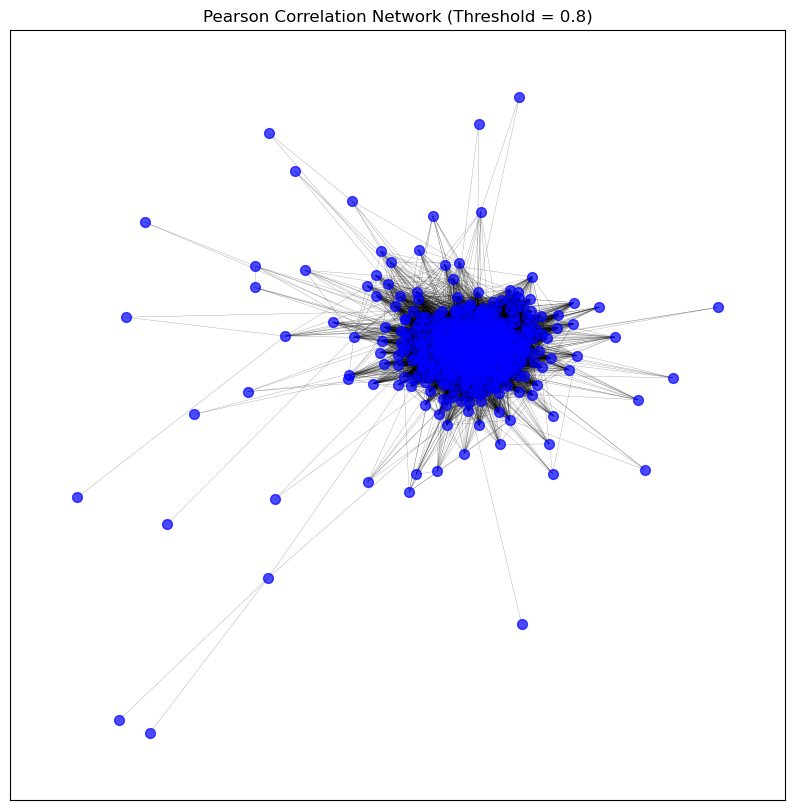

In [51]:
# Dictionary to store different correlation matrices
p_meth_correlation_matrices = {}

# Pearson correlation
p_meth_correlation_matrices['pearson'] = patient_meth_matrix.corr(method='pearson')

p_meth_pearson_graph = create_graph_from_correlation(p_meth_correlation_matrices['pearson'], threshold=0.8)
# Clean the graph by removing unconnected nodes
p_meth_pearson_graph_pruned = clean_graph(p_meth_pearson_graph,
                                    degree_threshold=1,
                                    keep_largest_component=True)

visualise_graph(p_meth_pearson_graph_pruned, title='Pearson Correlation Network (Threshold = 0.8)')

In [52]:
# sparseify the graph using knn_sparsification or any other method
p_meth_pearson_graph_pruned_knn = knn_sparsification(p_meth_pearson_graph_pruned, k=10)

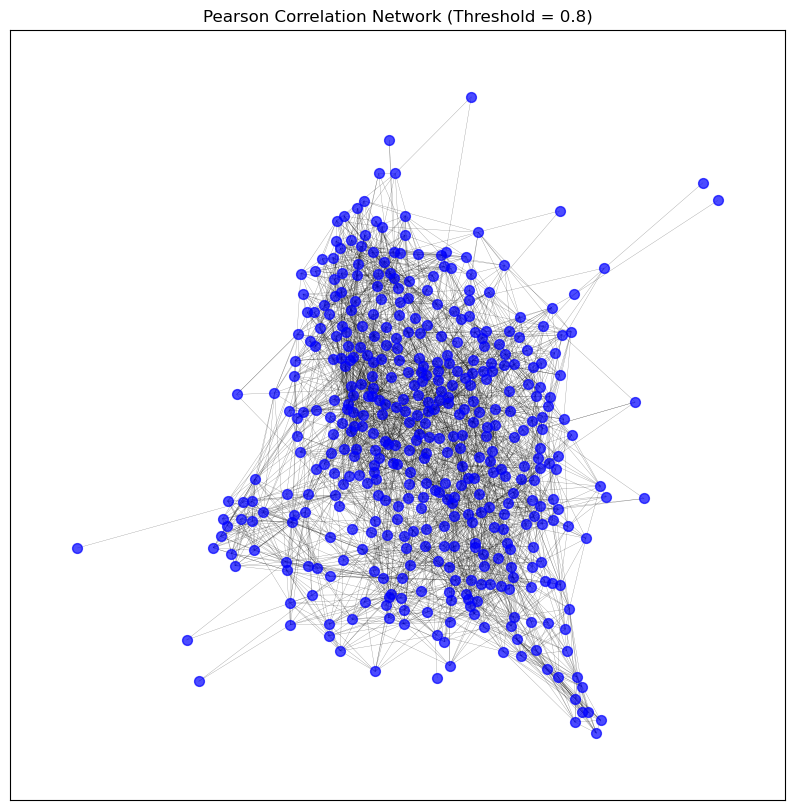

In [53]:
# visualise the graph using the visualise_graph function
visualise_graph(p_meth_pearson_graph_pruned_knn, title='Pearson Correlation Network (Threshold = 0.8)')